<a href="https://colab.research.google.com/github/Kodhandarama/Audio_Analysis/blob/master/pitch_contour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# connects colab to drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Projects/AA/Code/')

In [0]:
from scipy import signal

In [0]:
import librosa
import librosa.display
from swipe import *
import math

plt.rcParams['figure.figsize'] = [20,5]
# defining the class 
# each object of this class is an audio clip that is to be analysed
class Audio:
  def __init__(self, path, sr=None, duration = None):
    # loading the audio file
    self.x, self.sr1 = librosa.load(path= path, sr=sr,duration=duration)
    self.pitch_contour()
    self.diff = np.diff(self.pitch)
    self.constant_pitch(with_n = False)
    #self.tonic = self.find_tonic()
    #self.constant_pitch(with_n = True)
    self.find_gamaka()
    self.find_stationary_points()
  # computing pitch contour
  def pitch_contour(self,dt = 0.01):
    self.pitch, self.time_axis, self.s = swipe(self.x,self.sr1,[100, 500],dt, 0.4)
    #self.pitch = self.pitch.round(decimals = 2)

  def constant_pitch(self,with_n ):
    
    time_axis_80 = []
    pitch_80 = []
    constant_pitch_time_80=[]
    
    # normalised pitch by 12*log(to the base 2) (f[i]/f0)
    # where f0 is the tonic 
    if(with_n):

      self.normalised_pitch=[]
      
      for i in self.pitch:
        self.normalised_pitch.append((12*np.log2(i/self.tonic)))
      
      for i in range(0,len(self.time_axis),8):
        pitch_80.append(self.normalised_pitch[i])
        time_axis_80.append(self.time_axis[i])
      # calculating the 1st order difference
      delta = 0.3

    else:

      for i in range(0,len(self.time_axis),8):
        pitch_80.append(self.pitch[i])
        time_axis_80.append(self.time_axis[i])
      delta = 12
      
    diff_80 = np.diff(pitch_80)

    for i in range(len(diff_80)):
      # constant note when the slope(of the pitch contour) is within the thershold i.e, delta =  
      if(diff_80[i]<delta/2 and diff_80[i]>-delta/2):
        constant_pitch_time_80.append(time_axis_80[i])
    #self.constant_pitch_notes = [(i,j) for i,j in all_normalized_notes.items() if j in self.cpn]
    self.constant_pitch_time_80 = np.array(constant_pitch_time_80)

    cpt = list(self.constant_pitch_time_80.round(2))
    tim = []
    initial = cpt[0]
    c= initial
    for i in range(1,len(cpt)):
      check = round(cpt[i]-c,2)
      if(check == 0.08):
        pass
      else:
        tim.append((initial,c))
        initial = cpt[i]
      if i == (len(cpt)-1):
        c= cpt[i]
        tim.append((initial,c))
      c= cpt[i]
    ta = list(self.time_axis)
    self.cpn_and_t = []
    for i in tim:
      begin = int(100*i[0])
      end = int(100*i[1])
      self.cpn_and_t.append((self.pitch[begin:end],ta[begin:end]))
    self.cpn_and_t = np.array(self.cpn_and_t)
    g,h = self.cpn_and_t.T
    self.cpn = np.array([item for sublist in g for item in sublist])
    self.cpt = np.array([item for sublist in h for item in sublist])
  
  def find_gamaka(self):
    """
    self.gamaka = []
    diff_p = np.diff(self.pitch)
    for i in range(0,len(diff_p)):
      if abs(diff_p[i]>4) and self.pitch[i] not in self.cpn:
        self.gamaka.append([self.time_axis[i],self.pitch[i]])
    gamaka_T = np.array(self.gamaka)
    self.gamaka = gamaka_T.T
    """
    ta = list(self.time_axis)
    bt_cpt = []
    init = 0
    for _,j in self.cpn_and_t:
      if(j):
        bt_cpt.append([init,j[0]])
        init = j[-1]
    bt_cpn_cpt=[]
    for i in bt_cpt:
          begin = int(100*i[0])
          end = int(100*i[1])
          bt_cpn_cpt.append((self.pitch[begin:end],ta[begin:end]))
    self.bt_cpn_cpt = np.array(bt_cpn_cpt)
    self.bt_cpn,self.bt_cpt = self.bt_cpn_cpt.T
  
  def find_stationary_points(self):
    self.stp = []
    self.stp_t = []
    for i in range(len(self.bt_cpn)):
      test = self.bt_cpn[i]
      test_time  = self.bt_cpt[i]
      for i in signal.find_peaks(test)[0]:
        self.stp.append(test[i])
        self.stp_t.append(test_time[i])
      for i in signal.find_peaks(-1*test)[0]:
        self.stp.append(test[i])
        self.stp_t.append(test_time[i])

  def find_tonic(self):
    def most_frequent(List): 
      counter = 0
      num = List[0] 
        
      for i in List: 
          curr_frequency = List.count(i) 
          if(curr_frequency> counter): 
              counter = curr_frequency 
              num = i 
    
      return num

    store_tonic_pa=list()
    store_tonic_ri2=list()
    store_tonic_ma1=list()
    store_tonic_ga3=list()
    store_tonic_ni3=list()
    floored=[]
    toniclist=[]
    """
    uniquepitch=set(self.cpn)
    uniquepitchfloor=[]
    for i in uniquepitch:
      i=math.floor(i)
      uniquepitchfloor.append(i)
    """
    uniquepitchfloor = list(self.cpn.round())
    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            if(((i/j)>1.49) and ((i/j) <1.51)):
              store_tonic_pa.append(j)
            if(((i/j)>1.1) and ((i/j) <1.14) ):
              store_tonic_ri2.append(j)
    if(store_tonic_pa):
      pa_to_sa=most_frequent(store_tonic_pa)
      toniclist.append(pa_to_sa)
    else:
      toniclist.append(500)
    if(store_tonic_ri2):
      ri2_to_sa=most_frequent(store_tonic_ri2)
      toniclist.append(ri2_to_sa)
    else:
      toniclist.append(600)
    if(abs(toniclist[1]-toniclist[0])< 5):
      # print(toniclist[0])
      return toniclist[0]

    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            
            if(((i/j)>1.29) and ((i/j) <1.35) ):
            
              store_tonic_ma1.append(j)
    if(store_tonic_ma1):
      ma1_to_sa=most_frequent(store_tonic_ma1)
      toniclist.append(ma1_to_sa)
    else:
      toniclist.append(700)
    
    if((abs(toniclist[2]-toniclist[0])< 5) or (abs(toniclist[2]-toniclist[1])< 5)):
      # print(toniclist[2])
      return toniclist[2]

    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            if(((i/j)>1.2) and ((i/j) <1.27)):
              store_tonic_ga3.append(j)
    if(store_tonic_ga3):
      ga3_to_sa=most_frequent(store_tonic_ga3)
      toniclist.append(ga3_to_sa)
    else:
      toniclist.append(800)
    if((abs(toniclist[3]-toniclist[0])< 5) or (abs(toniclist[3]-toniclist[1])< 5) or (abs(toniclist[3]-toniclist[2])< 5)):
      # print(toniclist[3])
      return toniclist[3]

    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            if(((i/j)>1.85) and ((i/j) <1.9) ):
              
              store_tonic_ni3.append(j)
    if(store_tonic_ni3):
      ni3_to_sa=most_frequent(store_tonic_ni3)
      toniclist.append(ni3_to_sa)
    else:
      toniclist.append(900)   
    if((abs(toniclist[4]-toniclist[0])< 5) or (abs(toniclist[4]-toniclist[1])< 5) or (abs(toniclist[4]-toniclist[2])< 5) or (abs(toniclist[4]-toniclist[3])< 5)):
      print(toniclist[4])
      return toniclist[4]
    # print("tonic not found sigh")
    # print(toniclist[0])
    return -1 #lets just assume Pa was there
  def plot(self,**kwargs):
    for key,value in kwargs.items():
      if(key=='contour' and value):
        plt.plot(self.time_axis,self.pitch,label = 'Pitch Contour')
      if(key == 'cpn' and value):
        plt.plot(self.time_axis,self.pitch,c="#FF0000",label = 'Pitch Contour')
        plt.scatter(self.cpt,self.cpn,c='0',label = 'Constant Pitch')
      if(key == 'gamaka' and value):
        plt.scatter(self.gamaka[0],self.gamaka[1],c="#00FF00",label = 'Gamaka')
      if(key =='stp' and value):
        plt.scatter(self.stp_t,self.stp,c='#00FF00',label = 'Stationary Points')
        plt.plot(self.time_axis,self.pitch,c="#FF0000",label = 'Pitch Contour')
      plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

In [0]:
shankarabarana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Raga_Surabhi_3.wav')
kalyani_1 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_1.wav')
kalyani_2 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_2.wav')

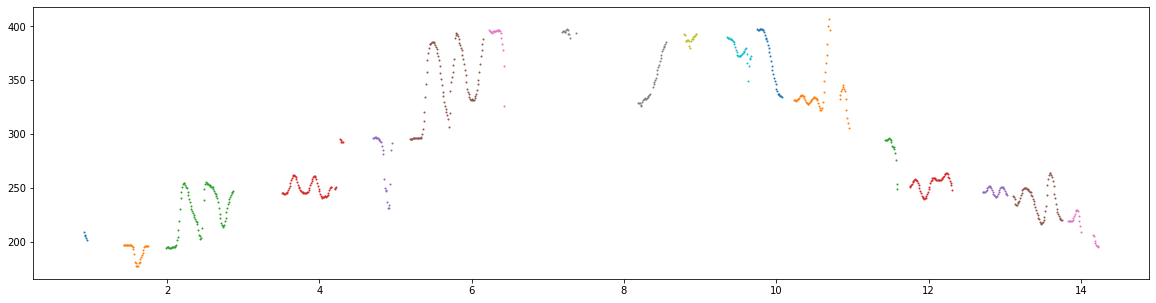

In [19]:
for i in range(len(shankarabarana.bt_cpn)):
  #print(h[i][-1]-h[i][0])
  plt.scatter(shankarabarana.bt_cpt[i],shankarabarana.bt_cpn[i],s = 1)

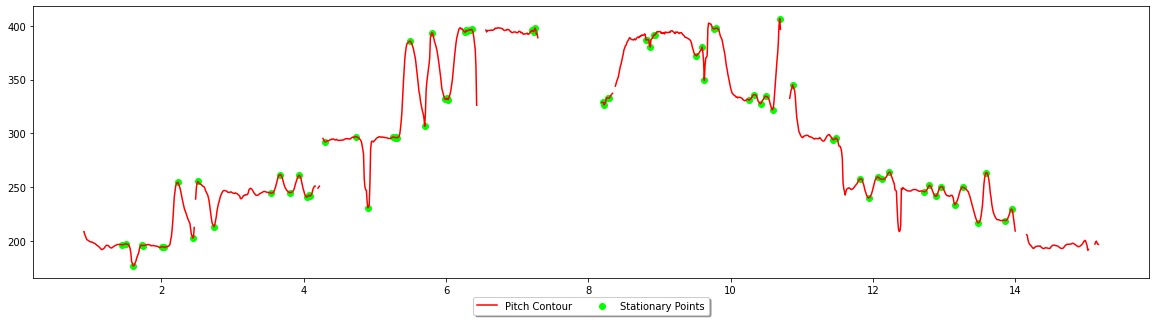

In [110]:
shankarabarana.plot(stp  = True)

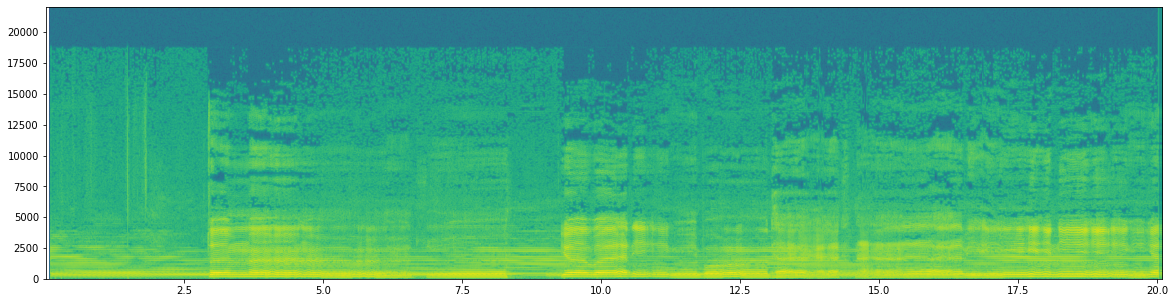

In [113]:
rkm = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223580__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-abhogi-raaga.mp3',duration=20)

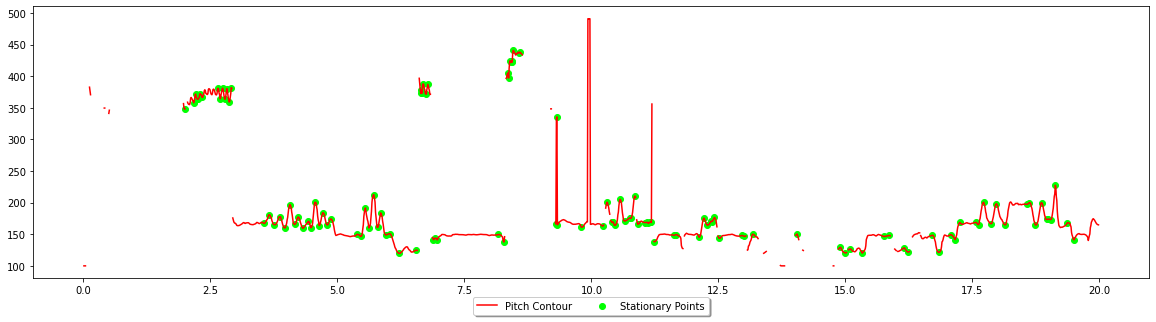

In [114]:
rkm.plot(stp = 1)